# Variational Autoencoder

## Setup

### Imports

In [89]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [90]:
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
import matplotlib.pyplot as plt

from autoencoders.variational_autoencoder import VariationalAutoencoder, Measure
from utils.stacked_mnist import StackedMNISTData, DataMode
from utils.verification_net import VerificationNet


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Configuration

In [91]:
encoding_dim = 16
epochs = 50
batch_size = 256
force_relearn = False
mono_tolerance = 0.8
stacked_tolerance = 0.5
n_generated = 10000
prior_distribution = tfd.Independent(tfd.Normal(loc=tf.zeros(encoding_dim), scale=1), reinterpreted_batch_ndims=1)


## Mono MNIST

### Data

In [92]:
gen = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE)
x_train, y_train = gen.get_full_data_set(training=True)
x_test, y_test = gen.get_full_data_set(training=False)

### Train

In [93]:
# Train autoencoder
autoencoder = VariationalAutoencoder(prior_distribution, encoding_dim, x_train.shape[1:3])
autoencoder.summary()
autoencoder.train(x_train, epochs=epochs, batch_size=batch_size, force_relearn=force_relearn)

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_7 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 14, 14, 16)        416       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 7, 7, 16)          6416      
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 4, 4, 32)          12832     
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 2, 2, 32)          25632     
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 1, 1, 64)          100416    
_________________________________________________________________
flatten_14 (Flatten)         (None, 64)                0   

True

In [94]:
# Train verification network
net = VerificationNet(force_learn=False)
net.train(generator=gen, epochs=epochs)

img, labels = gen.get_random_batch(training=True,  batch_size=25000)
cov = net.check_class_coverage(data=img, tolerance=.98)
pred, acc = net.check_predictability(data=img, correct_labels=labels)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

D:\Anaconda\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Coverage: 100.00%
Predictability: 98.37%
Accuracy: 98.10%


### Reconstruction

**Reconstruct images and display**

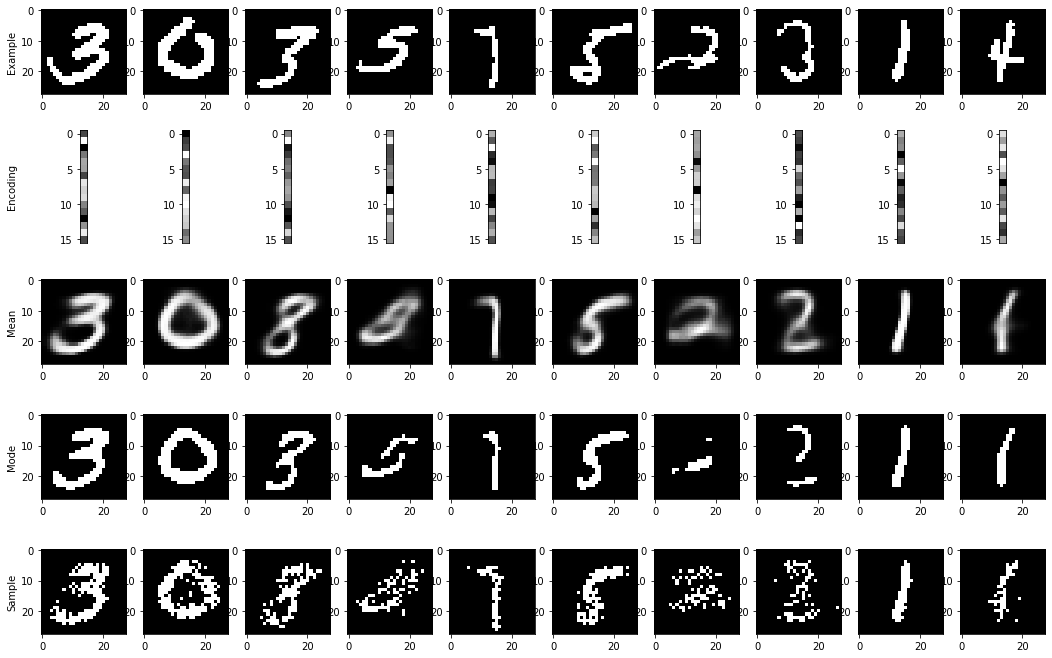

In [95]:
encoded = autoencoder.encode(x_test)

reconstructed_mean = autoencoder(x_test, output_measure=Measure.mean).numpy()
reconstructed_mode = autoencoder(x_test, output_measure=Measure.mode).numpy()
reconstructed_sample = autoencoder(x_test, output_measure=Measure.sample).numpy()

# Display some reconstructions
n_display = 10
idx = np.random.choice(x_test.shape[0], n_display, replace=False)
fig, ax = plt.subplots(5, n_display, figsize=(18, 12))
for i, n in enumerate(idx):
    ax[0][i].imshow(x_test[n], cmap='gray')
    ax[1][i].imshow(encoded[n], cmap='gray')
    ax[1][i].set_xticks([])
    ax[2][i].imshow(reconstructed_mean[n], cmap='gray')
    ax[3][i].imshow(reconstructed_mode[n], cmap='gray')
    ax[4][i].imshow(reconstructed_sample[n], cmap='gray')
ax[0][0].set_ylabel('Example')
ax[1][0].set_ylabel('Encoding')
ax[2][0].set_ylabel('Mean')
ax[3][0].set_ylabel('Mode')
ax[4][0].set_ylabel('Sample')
fig.align_ylabels()
plt.show()

**Assess reconstructions**

In [96]:
# Check coverage, predictability, and accuracy
print('---Mean---')
cov = net.check_class_coverage(data=reconstructed_mean, tolerance=mono_tolerance)
pred, acc = net.check_predictability(data=reconstructed_mean, correct_labels=y_test, tolerance=mono_tolerance)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

print('---Mode---')
cov = net.check_class_coverage(data=reconstructed_mode, tolerance=mono_tolerance)
pred, acc = net.check_predictability(data=reconstructed_mode, correct_labels=y_test, tolerance=mono_tolerance)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

print('---Sample---')
cov = net.check_class_coverage(data=reconstructed_sample, tolerance=mono_tolerance)
pred, acc = net.check_predictability(data=reconstructed_sample, correct_labels=y_test, tolerance=mono_tolerance)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

---Mean---
Coverage: 80.00%
Predictability: 58.40%
Accuracy: 36.31%
---Mode---
Coverage: 100.00%
Predictability: 94.48%
Accuracy: 82.96%
---Sample---
Coverage: 100.00%
Predictability: 80.68%
Accuracy: 72.76%


### Generation

**Generate images and display**

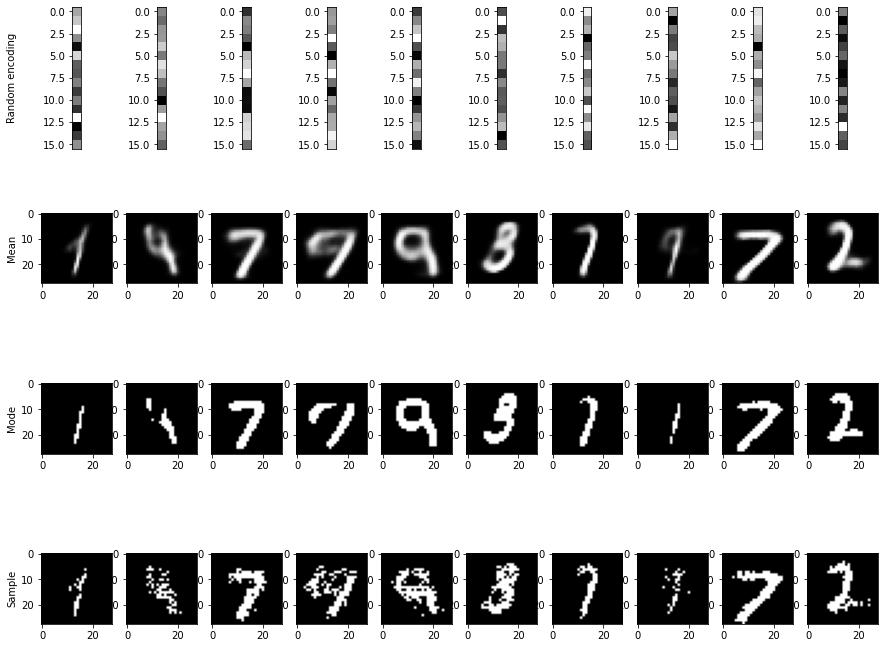

In [97]:
z = tf.reshape(prior_distribution.sample(n_generated), (n_generated, encoding_dim, 1))
generated_mean = autoencoder.decode(z, output_measure=Measure.mean).numpy()
generated_mode = autoencoder.decode(z, output_measure=Measure.mode).numpy()
generated_sample = autoencoder.decode(z, output_measure=Measure.sample).numpy()

# Display some generated images
n_display = 10
idx = np.random.choice(z.shape[0], n_display, replace=False)
fig, ax = plt.subplots(4, n_display, figsize=(15, 12))
for i, n in enumerate(idx):
    ax[0][i].imshow(z[n], cmap='gray')
    ax[0][i].set_xticks([])
    ax[1][i].imshow(generated_mean[n], cmap='gray')
    ax[2][i].imshow(generated_mode[n], cmap='gray')
    ax[3][i].imshow(generated_sample[n], cmap='gray')

ax[0][0].set_ylabel('Random encoding')
ax[1][0].set_ylabel('Mean')
ax[2][0].set_ylabel('Mode')
ax[3][0].set_ylabel('Sample')
fig.align_ylabels()
plt.show()

**Assess generation**

In [98]:
# Check coverage, predictability, and accuracy
print('---Mean---')
cov = net.check_class_coverage(data=generated_mean, tolerance=mono_tolerance)
pred, _ = net.check_predictability(data=generated_mean, tolerance=mono_tolerance)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

print('---Mode---')
cov = net.check_class_coverage(data=generated_mode, tolerance=mono_tolerance)
pred, _ = net.check_predictability(data=generated_mode, tolerance=mono_tolerance)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

print('---Sample---')
cov = net.check_class_coverage(data=generated_sample, tolerance=mono_tolerance)
pred, _ = net.check_predictability(data=generated_sample, tolerance=mono_tolerance)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

---Mean---
Coverage: 80.00%
Predictability: 55.85%
---Mode---
Coverage: 100.00%
Predictability: 84.38%
---Sample---
Coverage: 100.00%
Predictability: 59.41%


### Anomaly Detection

**Train new model**

In [99]:
missing_gen = StackedMNISTData(mode=DataMode.MONO_BINARY_MISSING)

# Train autoencoder
x_train_missing, y_train_missing = missing_gen.get_full_data_set(training=True)

missing_autoencoder = VariationalAutoencoder(prior_distribution, encoding_dim, x_train_missing.shape[1:3], file_name="./models/variational_missing_autoencoder/autoencoder")
missing_autoencoder.summary()
missing_autoencoder.train(x_train_missing, epochs=epochs, batch_size=batch_size, force_relearn=force_relearn)


Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_8 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 14, 14, 16)        416       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 7, 7, 16)          6416      
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 4, 4, 32)          12832     
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 2, 2, 32)          25632     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 1, 1, 64)          100416    
_________________________________________________________________
flatten_17 (Flatten)         (None, 64)                0   

True

In [100]:
# Calculating probability test set with no missing digits
loss = missing_autoencoder.sampled_loss(x_test)

Channel 1
0 / 10000
1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000


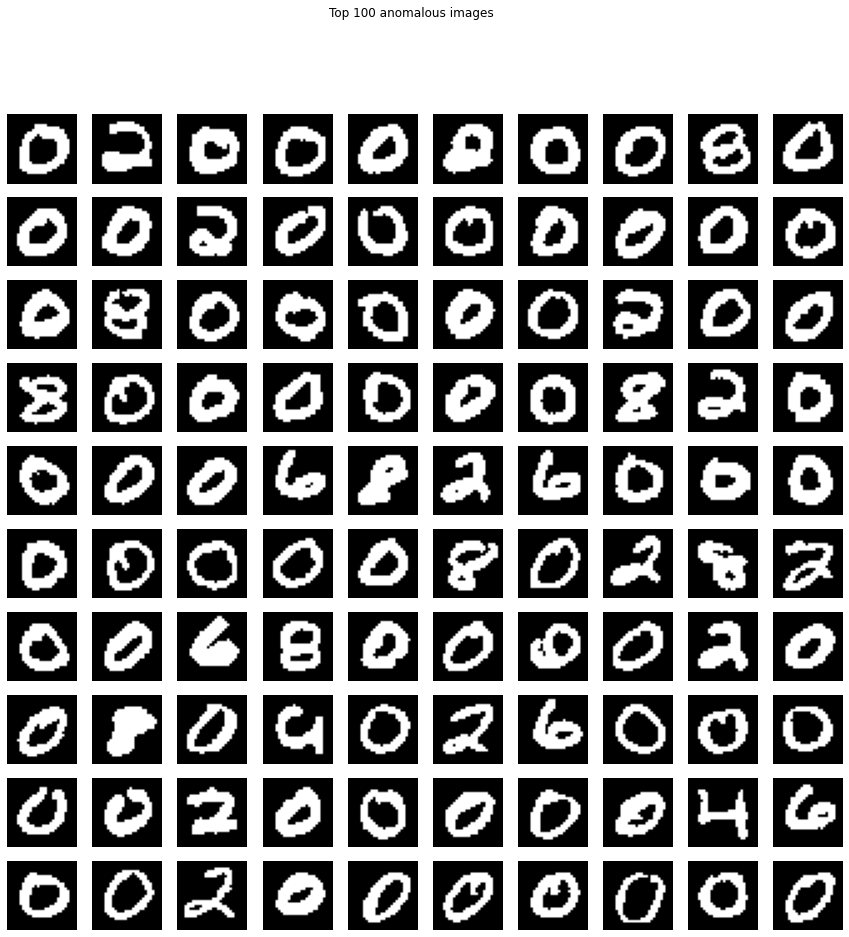

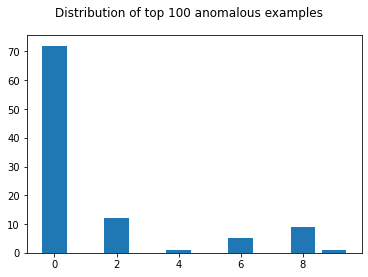

10 most anomolous labels: [0 2 0 0 0 2 0 0 8 0]


In [ ]:
# Display most anomolous images

grid_size = 10
# Get n largest loss indexes
idx = (-loss).argsort()[:grid_size**2]
fig, ax = plt.subplots(grid_size, grid_size, figsize=(15, 15))
for n in range(grid_size):
    for m in range(grid_size): 
        ax[n][m].imshow(x_test[idx[grid_size*n + m]], cmap='gray')
        ax[n][m].axis('off')
fig.suptitle(f'Top {grid_size**2} anomalous images')
plt.show()
unique, counts = np.unique(y_test[idx], return_counts=True)
fig, ax = plt.subplots()
ax = plt.bar(unique, counts)
fig.suptitle(f'Distribution of top {grid_size**2} anomalous examples')
plt.show()
print('10 most anomolous labels:', y_test[idx][:10])

## Color MNIST

### Data

In [ ]:
color_gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE)
x_train_color, y_train_color = color_gen.get_full_data_set(training=True)
x_test_color, y_test_color = color_gen.get_full_data_set(training=False)

### Train

In [ ]:
color_autoencoder = VariationalAutoencoder(prior_distribution=prior_distribution, encoding_dim=encoding_dim, image_dim=x_train_color.shape[1:3], file_name='./models/color_variational_autoencoder/autoencoder')
color_autoencoder.summary()
color_autoencoder.train(x_train_color, epochs=epochs, batch_size=batch_size, force_relearn=force_relearn)

Could not read weights for autoencoder from file. Must retrain...
Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 14, 16)        416       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 7, 7, 16)          6416      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 4, 4, 32)          12832     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 2, 2, 32)          25632     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 1, 1, 64)          100416    
___________________________________________________________

KeyboardInterrupt: 

### Reconstruction

**Reconstruct images and display**

In [ ]:
encoded = color_autoencoder.encode(x_test_color)

reconstructed_mean = color_autoencoder(x_test_color, output_measure=Measure.mean).numpy()
reconstructed_mode = color_autoencoder(x_test_color, output_measure=Measure.mode).numpy()
reconstructed_sample = color_autoencoder(x_test_color, output_measure=Measure.sample).numpy()

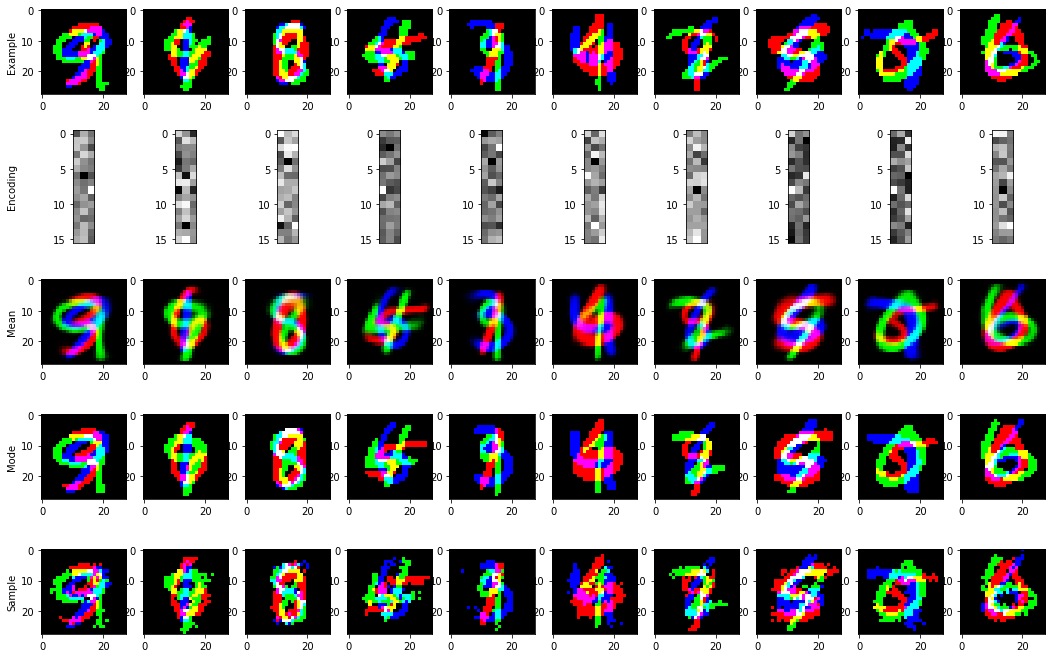

In [ ]:
# Display some reconstructions
n_display = 10
idx = np.random.choice(x_test_color.shape[0], n_display, replace=False)
fig, ax = plt.subplots(5, n_display, figsize=(18, 12))
for i, n in enumerate(idx):
    ax[0][i].imshow(x_test_color[n] * 255)
    ax[1][i].imshow(encoded[n], cmap='gray')
    ax[1][i].set_xticks([])
    ax[2][i].imshow(reconstructed_mean[n])
    ax[3][i].imshow(reconstructed_mode[n])
    ax[4][i].imshow(reconstructed_sample[n])
ax[0][0].set_ylabel('Example')
ax[1][0].set_ylabel('Encoding')
ax[2][0].set_ylabel('Mean')
ax[3][0].set_ylabel('Mode')
ax[4][0].set_ylabel('Sample')
fig.align_ylabels()
plt.show()

**Assess reconstruction**

In [ ]:
# Check coverage, predictability, and accuracy
print('---Mean---')
cov = net.check_class_coverage(data=reconstructed_mean, tolerance=stacked_tolerance)
pred, acc = net.check_predictability(data=reconstructed_mean, correct_labels=y_test_color, tolerance=stacked_tolerance)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

print('---Mode---')
cov = net.check_class_coverage(data=reconstructed_mode, tolerance=stacked_tolerance)
pred, acc = net.check_predictability(data=reconstructed_mode, correct_labels=y_test_color, tolerance=stacked_tolerance)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

print('---Sample---')
cov = net.check_class_coverage(data=reconstructed_sample, tolerance=stacked_tolerance)
pred, acc = net.check_predictability(data=reconstructed_sample, correct_labels=y_test_color, tolerance=stacked_tolerance)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

---Mean---
Coverage: 98.30%
Predictability: 78.34%
Accuracy: 54.69%
---Mode---
Coverage: 100.00%
Predictability: 98.74%
Accuracy: 86.29%
---Sample---
Coverage: 100.00%
Predictability: 95.02%
Accuracy: 81.75%


### Generation

**Generate images and display**

In [ ]:
z = tf.reshape(prior_distribution.sample(n_generated * 3), (n_generated, encoding_dim, 3))
generated_mean = autoencoder.decode(z, output_measure=Measure.mean).numpy()
generated_mode = autoencoder.decode(z, output_measure=Measure.mode).numpy()
generated_sample = autoencoder.decode(z, output_measure=Measure.sample).numpy()

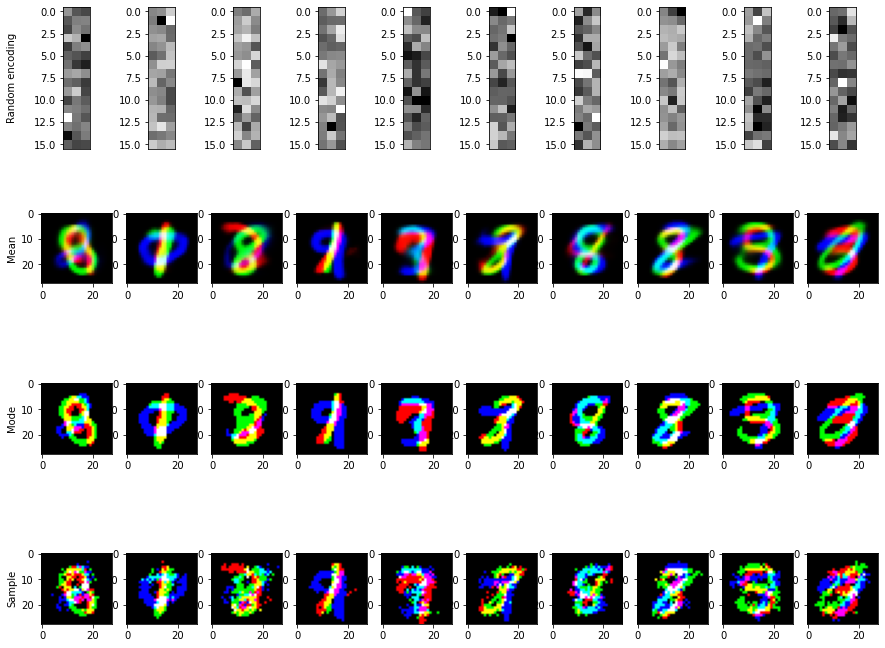

In [ ]:
# Display some generated images
n_display = 10
idx = np.random.choice(z.shape[0], n_display, replace=False)
fig, ax = plt.subplots(4, n_display, figsize=(15, 12))
for i, n in enumerate(idx):
    ax[0][i].imshow(z[n], cmap='gray')
    ax[0][i].set_xticks([])
    ax[1][i].imshow(generated_mean[n])
    ax[2][i].imshow(generated_mode[n])
    ax[3][i].imshow(generated_sample[n])

ax[0][0].set_ylabel('Random encoding')
ax[1][0].set_ylabel('Mean')
ax[2][0].set_ylabel('Mode')
ax[3][0].set_ylabel('Sample')
fig.align_ylabels()
plt.show()

**Assess generation**

In [ ]:
# Check coverage, predictability, and accuracy
print('---Mean---')
cov = net.check_class_coverage(data=generated_mean, tolerance=stacked_tolerance)
pred, _ = net.check_predictability(data=generated_mean, tolerance=stacked_tolerance)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

print('---Mode---')
cov = net.check_class_coverage(data=generated_mode, tolerance=stacked_tolerance)
pred, _ = net.check_predictability(data=generated_mode, tolerance=stacked_tolerance)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

print('---Sample---')
cov = net.check_class_coverage(data=generated_sample, tolerance=stacked_tolerance)
pred, _ = net.check_predictability(data=generated_sample, tolerance=stacked_tolerance)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

---Mean---
Coverage: 47.70%
Predictability: 49.63%
---Mode---
Coverage: 100.00%
Predictability: 89.75%
---Sample---
Coverage: 99.30%
Predictability: 67.87%


### Anomaly Detection

**Train new model**

In [ ]:
color_missing_gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_MISSING)

# Train autoencoder
x_train_color_missing, y_train_color_missing = color_missing_gen.get_full_data_set(training=True)

color_missing_autoencoder = VariationalAutoencoder(prior_distribution, encoding_dim, x_train_color_missing.shape[1:3], file_name="./models/variational_missing_autoencoder/autoencoder")
color_missing_autoencoder.summary()
color_missing_autoencoder.train(x_train_color_missing, epochs=epochs, batch_size=batch_size, force_relearn=force_relearn)


Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 14, 14, 16)        416       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 7, 7, 16)          6416      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 4, 4, 32)          12832     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 2, 2, 32)          25632     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 1, 1, 64)          100416    
_________________________________________________________________
flatten_10 (Flatten)         (None, 64)                0   

True

In [ ]:
# Calculating probability test set with no missing digits
loss = color_missing_autoencoder.sampled_loss(x_test_color)

Channel 1
0 / 10000
1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000
8000 / 10000
9000 / 10000
10000 / 10000
Channel 2
0 / 10000
1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000
8000 / 10000
9000 / 10000
10000 / 10000
Channel 3
0 / 10000
1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000
8000 / 10000
9000 / 10000
10000 / 10000


In [ ]:
loss = np.mean(loss, axis=1)

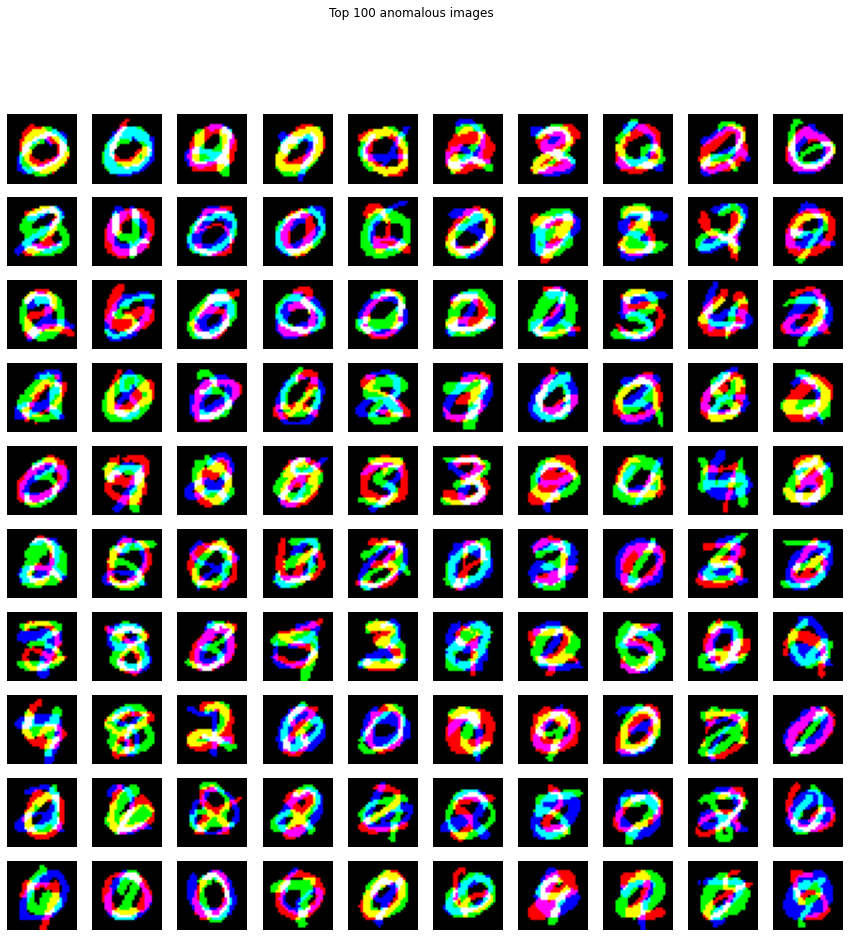

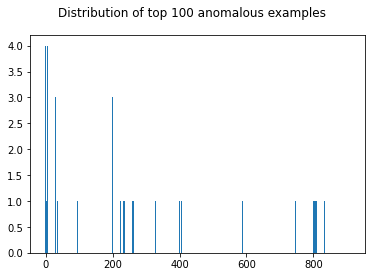

10 most anomolous labels: [  0   6 240 700 400 220 328 260 220  60]


In [ ]:
# Display most anomolous images

grid_size = 10
# Get n largest loss indexes
idx = (-loss).argsort()[:grid_size**2]
fig, ax = plt.subplots(grid_size, grid_size, figsize=(15, 15))
for n in range(grid_size):
    for m in range(grid_size): 
        ax[n][m].imshow(x_test_color[idx[grid_size*n + m]]*255)
        ax[n][m].axis('off')
fig.suptitle(f'Top {grid_size**2} anomalous images')
plt.show()
unique, counts = np.unique(y_test_color[idx], return_counts=True)
fig, ax = plt.subplots()
ax = plt.bar(unique, counts)
fig.suptitle(f'Distribution of top {grid_size**2} anomalous examples')
plt.show()
print('10 most anomolous labels:', y_test_color[idx][:10])